# Download the Data

In [ ]:
# !pip3 install tqdm

In [67]:
import os
import json
import urllib
import shutil
import random
import tarfile

from glob import glob
from tqdm import tqdm

In [3]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt

In [4]:
urls = [
    'http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz',
    'http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz'
]

In [5]:
def download_and_extract(data_dir, download_dir):
    for url in urls:
        target_file = url.split('/')[-1]
        if target_file not in os.listdir(download_dir):
            print('Downloading', url)
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))
            tf = tarfile.open(url.split('/')[-1])
            tf.extractall(data_dir)
        else:
            print('Already downloaded', url)

In [6]:
def get_annotations(file_path):
    annotations = {}
    
    with open(file_path, 'r') as f:
        rows = f.read().splitlines()

    for i, row in enumerate(rows):
        image_name, _, _, _ = row.split(' ')
        class_name = image_name.split('_')[:-1]
        class_name = '_'.join(class_name)
        image_name = image_name + '.jpg'
        annotations[image_name] = class_name
    
    return annotations, i + 1

In [7]:
data_dir = '/home/ec2-user/SageMaker/data'

if not os.path.isdir('data'):
    os.mkdir('data')

download_and_extract(data_dir, '.')

Already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz


In [8]:
train_annotations, _ = get_annotations(f'{data_dir}/annotations/trainval.txt')
test_annotations, _ = get_annotations(f'{data_dir}/annotations/test.txt')

In [9]:
all_annotations = {}

for key, value in train_annotations.items():
    all_annotations[key] = value
    
for key, value in test_annotations.items():
    all_annotations[key] = value

In [10]:
train_annotations = {}
test_annotations = {}

for key, value in all_annotations.items():
    if random.randint(0, 99) < 20:
        test_annotations[key] = value
    else:
        train_annotations[key] = value

In [11]:
train_count = len(list(train_annotations.keys()))
test_count = len(list(test_annotations.keys()))

print(train_count)
print(test_count)

5879
1470


# Visualize Data

In [12]:
classes = list(all_annotations.values())
classes = list(set(classes))

In [13]:
len(classes)

37

In [14]:
classes[:5]

['japanese_chin', 'chihuahua', 'newfoundland', 'Persian', 'Ragdoll']

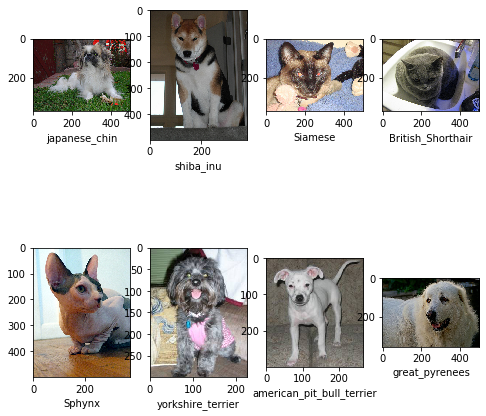

In [15]:
plt.figure(figsize=(8, 8))

train_images = list(train_annotations.keys())

for i in range(0, 8):
    plt.subplot(2, 4, i + 1)
    image = train_images[random.randint(0, train_count - 1)]
    plt.imshow(plt.imread(os.path.join(f'{data_dir}/images/', image)))
    plt.xlabel(train_annotations[image])
    
plt.show()

# SageMaker Setup

In [16]:
import sagemaker

role = sagemaker.get_execution_role()
sess = sagemaker.Session()

In [17]:
import boto3
region_name = boto3.Session().region_name

In [18]:
from sagemaker.amazon.amazon_estimator import get_image_uri
training_image = get_image_uri(region_name, 'image-classification', repo_version='latest')

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


In [19]:
training_image

'811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:1'

In [20]:
folders = ['train', 'train_lst', 'validation', 'validation_lst']

for folder in folders:
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)

# Preparing Data for SageMaker

In [21]:
def prepare_data(annotations, key='train'):
    images = list(annotations.keys())
    f = open(os.path.join(key + '_lst', key + '.lst'), 'w')
    
    with tqdm(total=len(images)) as pbar:
        for i, image in enumerate(images):
            shutil.copy(os.path.join(f'{data_dir}/images/', image), os.path.join(key, image))
            class_id = classes.index(annotations[image])
            f.write('{}\t{}\t{}\n'.format(i, class_id, image))
            pbar.update(1)
    
    f.close()

In [22]:
prepare_data(train_annotations, 'train')

100%|██████████| 5879/5879 [00:14<00:00, 400.98it/s]


In [23]:
prepare_data(test_annotations, 'validation')

100%|██████████| 1470/1470 [00:04<00:00, 356.51it/s]


# Uploading Data to S3

In [24]:
bucket = sess.default_bucket()
bucket

'sagemaker-us-east-1-448873806592'

In [36]:
s3_data_path = f's3://{bucket}/pets/image-classification/20210607'

In [37]:
# %%time

# folders = ['train', 'train_lst', 'validation', 'validation_lst']
# s3_path_mapping = {}

# for folder in folders:
#     s3_path = sess.upload_data(
#         path=folder, 
#         bucket=bucket, 
#         key_prefix=f'pets/image-classification/{folder}'
#     )
    
#     s3_path_mapping[folder] = s3_path
    
#     print(f'{folder} uploaded')

In [41]:
!aws s3 sync . $s3_data_path/

upload: ./Image Classification - Learner Notebook.ipynb to s3://sagemaker-us-east-1-448873806592/pets/image-classification/20210607/Image Classification - Learner Notebook.ipynb
                                                                                     


In [42]:
!aws s3 ls $s3_data_path/

                           PRE .ipynb_checkpoints/
                           PRE train/
                           PRE train_lst/
                           PRE validation/
                           PRE validation_lst/
2021-06-07 13:18:29     287943 Image Classification - Learner Notebook.ipynb
2021-06-07 12:59:21   19173078 annotations.tar.gz
2021-06-07 12:59:21  791918971 images.tar.gz


# SageMaker Estimator

In [58]:
model = sagemaker.estimator.Estimator(
    image_uri=training_image,
    role=role,
    instance_count=1,
    instance_type='ml.p2.xlarge',
    volume_size=100,
    max_run=86400,
    input_mode='File',
    output_path=f'{s3_data_path}/output',
    sagemaker_session=sess
)

# Hyperparameters

In [59]:
model.set_hyperparameters(
    num_layers=18,
    use_pretrained_model=1,
    image_shape='3,224,224',
    num_classes=len(classes),
    mini_batch_size=32,
    resize=224,
    epochs=10,
    learning_rate=0.001,
    num_training_samples=train_count,
    augmentation_type='crop_color_transform'
)

# Data Channels

In [45]:
!aws s3 ls $s3_data_path/

                           PRE .ipynb_checkpoints/
                           PRE train/
                           PRE train_lst/
                           PRE validation/
                           PRE validation_lst/
2021-06-07 13:18:29     287943 Image Classification - Learner Notebook.ipynb
2021-06-07 12:59:21   19173078 annotations.tar.gz
2021-06-07 12:59:21  791918971 images.tar.gz


In [52]:
train_data = sagemaker.inputs.TrainingInput(
    s3_data=f'{s3_data_path}/train/',
    distribution='FullyReplicated',
    content_type='application/x-image',
    s3_data_type='S3Prefix'
)

validation_data = sagemaker.inputs.TrainingInput(
    s3_data=f'{s3_data_path}/validation/',
    distribution='FullyReplicated',
    content_type='application/x-image',
    s3_data_type='S3Prefix'
)

train_lst_data = sagemaker.inputs.TrainingInput(
    s3_data=f'{s3_data_path}/train_lst/',
    distribution='FullyReplicated',
    content_type='application/x-image',
    s3_data_type='S3Prefix'
)

validation_lst_data = sagemaker.inputs.TrainingInput(
    s3_data=f'{s3_data_path}/validation_lst/',
    distribution='FullyReplicated',
    content_type='application/x-image',
    s3_data_type='S3Prefix'
)

In [56]:
data_channels = {
    'train': train_data,
    'train_lst': train_lst_data,
    'validation': validation_data,
    'validation_lst': validation_lst_data,
}

# Model Training

In [60]:
model.fit(inputs=data_channels, logs=True)

2021-06-07 13:29:46 Starting - Starting the training job...
2021-06-07 13:30:10 Starting - Launching requested ML instancesProfilerReport-1623072586: InProgress
......
2021-06-07 13:31:16 Starting - Preparing the instances for training...............
2021-06-07 13:33:31 Downloading - Downloading input data......
2021-06-07 13:34:40 Training - Downloading the training image...
2021-06-07 13:35:11 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
[06/07/2021 13:35:07 INFO 140164608321344] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/image_classification/default-input.json: {'use_pretrained_model': 0, 'num_layers': 152, 'epochs': 30, 'learning_rate': 0.1, 'lr_scheduler_factor': 0.1, 'optimizer': 'sgd', 'momentum': 0, 'weight_decay': 0.0001, 'beta_1': 0.9, 'beta_2': 0.999, 'eps': 1e-08, 'gamma': 0.9, 'mini_batch_size': 32, 'image_shape': '3,224,224', 'precision_dtype': 'float32'}
[06/07/2021 13:

# Deploy Model

In [61]:
deployed_model = model.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge'
)

-----------------!

In [79]:
deployed_model.content_type = 'image/jpeg'

AttributeError: can't set attribute

In [80]:
deployed_model.__dict__.keys()

dict_keys(['endpoint_name', 'sagemaker_session', 'serializer', 'deserializer', '_endpoint_config_name', '_model_names', '_context'])

# Predictions

In [63]:
image_dir = 'validation'

In [69]:
files = glob('validation/*jpg')

In [74]:
img_path = random.choice(files)
img_path

'validation/english_setter_164.jpg'

In [75]:
with open(img_path, 'rb') as fh:
    image_bytes = bytearray(fh.read())

In [76]:
results = deployed_model.predict(image_bytes)
results = json.loads(results)
results

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received client error (415) from model with message "content-type application/octet-stream not supported". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/image-classification-2021-06-07-13-44-50-342 in account 448873806592 for more information.

In [ ]:
plt.plot(range(37), results)

In [ ]:
classes[np.argmax(results)]

In [ ]:
plt.imshow(plt.imread(image_path))
plt.xlabel(images[index])
plt.show()a

# Cleanup

In [81]:
sagemaker.Session().delete_endpoint(deployed_model.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
